### Author
 - Gioele Modica

In [241]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML, display
import matplotlib.animation as animation
from skimage.transform import resize

# Functions

In [242]:
def load_dicom_series(directory):
    """Load a series of DICOM files from a directory and return as 3D numpy array"""
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in sorted(os.listdir(directory))]
    slices = [f.pixel_array for f in files]
    return np.stack(slices, axis=0)

def load_single_dicom(filepath):
    """Load a single DICOM file"""
    ds = pydicom.dcmread(filepath)
    return ds.pixel_array

In [243]:
def extract_bounding_box(mask_volume):
    """Extract 3D bounding box coordinates from a binary mask volume"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    if len(props) == 0:
        return None
        
    bbox = props[0].bbox  # (min_z, min_y, min_x, max_z, max_y, max_x)
    return {
        'z_start': bbox[0],
        'z_end': bbox[3],
        'y_start': bbox[1],
        'y_end': bbox[4],
        'x_start': bbox[2],
        'x_end': bbox[5]
    }

In [244]:
def plot_slice_with_bbox(image_slice, mask_slice=None, bbox_coords=None, title=None):
    """Plot slice with mask and bounding box rectangle"""
    plt.figure(figsize=(10, 5))
    plt.imshow(image_slice, cmap='gray')
    
    if mask_slice is not None:
        mask_slice = np.ma.masked_where(mask_slice == 0, mask_slice)
        plt.imshow(mask_slice, cmap='autumn', alpha=0.3, label='Tumor Mask')
    
    if bbox_coords is not None:
        # Draw bounding box rectangle
        width = bbox_coords['x_end'] - bbox_coords['x_start']
        height = bbox_coords['y_end'] - bbox_coords['y_start']
        rect = plt.Rectangle((bbox_coords['x_start'], bbox_coords['y_start']),
                            width, height,
                            linewidth=2, edgecolor='lime', 
                            facecolor='none', label='Bounding Box')
        plt.gca().add_patch(rect)
    
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

In [245]:
def crop_to_bbox(volume, bbox):
    """Crop a 3D volume to bounding box dimensions"""
    return volume[bbox['z_start']:bbox['z_end'],
                bbox['y_start']:bbox['y_end'],
                bbox['x_start']:bbox['x_end']]

In [246]:
from scipy.ndimage import gaussian_gradient_magnitude

def region_growing_segmentation(image_volume, seed_point, threshold=20, bbox=None, gradient_thresh=10):
    """
    Perform 3D region growing segmentation with:
      - 26-connectivity
      - adaptive region-mean thresholding
      - optional gradient-based stopping
    Args:
        image_volume: 3D numpy array of the input volume
        seed_point: Dict with 'z','y','x' coordinates
        threshold: Initial intensity diff threshold
        bbox: Optional bounding box dict with z_start,z_end,y_start,y_end,x_start,x_end
        gradient_thresh: Max gradient magnitude allowed (to respect edges)
    Returns:
        segmented: binary 3D numpy array of the region
    """
    # Precompute gradient magnitude for edge detection
    grad_vol = gaussian_gradient_magnitude(image_volume.astype(float), sigma=1)

    # Initialize segmented map and queue
    segmented = np.zeros_like(image_volume, dtype=np.uint8)
    z0, y0, x0 = seed_point['z'], seed_point['y'], seed_point['x']

    # Check seed inside bbox if provided
    if bbox:
        if not (bbox['z_start'] <= z0 < bbox['z_end'] and
                bbox['y_start'] <= y0 < bbox['y_end'] and
                bbox['x_start'] <= x0 < bbox['x_end']):
            raise ValueError("Seed point outside bounding box")

    # Region statistics
    region_sum = float(image_volume[z0, y0, x0])
    region_count = 1
    region_mean = region_sum / region_count

    # Use full 26-connectivity
    neigh_offsets = [(dz, dy, dx)
                     for dz in [-1,0,1] for dy in [-1,0,1] for dx in [-1,0,1]
                     if not (dz==dy==dx==0)]

    # Initialize
    segmented[z0, y0, x0] = 1
    queue = [(z0, y0, x0)]

    while queue:
        cz, cy, cx = queue.pop(0)
        for dz, dy, dx in neigh_offsets:
            nz, ny, nx = cz+dz, cy+dy, cx+dx

            # Volume bounds
            if not (0 <= nz < image_volume.shape[0] and
                    0 <= ny < image_volume.shape[1] and
                    0 <= nx < image_volume.shape[2]):
                continue

            # Bbox constraint
            if bbox:
                if not (bbox['z_start'] <= nz < bbox['z_end'] and
                        bbox['y_start'] <= ny < bbox['y_end'] and
                        bbox['x_start'] <= nx < bbox['x_end']):
                    continue

            # Not already segmented
            if segmented[nz, ny, nx]:
                continue

            voxel_val = image_volume[nz, ny, nx]
            grad_val = grad_vol[nz, ny, nx]

            # Check intensity difference vs region mean AND gradient constraint
            if (abs(float(voxel_val) - region_mean) < threshold
                    and grad_val < gradient_thresh):
                # Accept the voxel
                segmented[nz, ny, nx] = 1
                queue.append((nz, ny, nx))

                # Update region stats
                region_sum += float(voxel_val)
                region_count += 1
                region_mean = region_sum / region_count

    return segmented


In [247]:
def compare_masks(ground_truth, predicted):
    """Compare two binary masks and calculate Dice and Jaccard coefficients"""
    # Assicuriamoci che le maschere abbiano le stesse dimensioni
    if ground_truth.shape != predicted.shape:
        # Trova la dimensione minima comune
        min_z = min(ground_truth.shape[0], predicted.shape[0])
        min_y = min(ground_truth.shape[1], predicted.shape[1])
        min_x = min(ground_truth.shape[2], predicted.shape[2])
        
        # Ritaglia entrambe le maschere alla stessa dimensione
        gt_cropped = ground_truth[:min_z, :min_y, :min_x]
        pred_cropped = predicted[:min_z, :min_y, :min_x]
    else:
        gt_cropped = ground_truth
        pred_cropped = predicted
    
    # Calcola le metriche sulle maschere ritagliate
    intersection = np.logical_and(gt_cropped, pred_cropped)
    union = np.logical_or(gt_cropped, pred_cropped)
    
    dice = 2 * intersection.sum() / (gt_cropped.sum() + pred_cropped.sum())
    jaccard = intersection.sum() / union.sum()
    
    return {
        'dice': dice,
        'jaccard': jaccard,
        'voxel_accuracy': (gt_cropped == pred_cropped).mean()
    }

In [248]:
def postprocess_segmentation(mask_volume, min_volume=100):
    """Remove small disconnected regions from segmentation"""
    labeled = label(mask_volume)
    props = regionprops(labeled)
    
    # Create new mask keeping only large enough regions
    cleaned = np.zeros_like(mask_volume)
    for prop in props:
        if prop.area >= min_volume:
            for coord in prop.coords:
                cleaned[coord[0], coord[1], coord[2]] = 1
                
    return cleaned

In [249]:
def plot_slice_with_masks(image_slice, gt_mask=None, pred_mask=None, title=None):
    """Plot a single slice with optional ground truth and predicted masks overlay"""
    plt.figure(figsize=(10, 5))
    
    plt.imshow(image_slice, cmap='gray')
    
    if gt_mask is not None:
        gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
        plt.imshow(gt_mask, cmap='autumn', alpha=0.3, label='Ground Truth')
    
    if pred_mask is not None:
        pred_mask = np.ma.masked_where(pred_mask == 0, pred_mask)
        plt.imshow(pred_mask, cmap='winter', alpha=0.3, label='Predicted')
    
    if title:
        plt.title(title)
    
    plt.legend()
    plt.show()

In [250]:
def plot_multiplanar_slices(volume, mask, cross_coords=None):
    """
    Plot axial, sagittal and coronal slices with mask overlay in a 1x3 grid,
    resizing sagittal and coronal to match the axial slice dimensions.
    """
    # Get the seed slice indices
    z, y, x = cross_coords['z'], cross_coords['y'], cross_coords['x']

    # Extract the three raw views
    axial_img, axial_msk     = volume[z],       mask[z]
    sagittal_img, sagittal_msk = volume[:, :, x], mask[:, :, x]
    coronal_img, coronal_msk   = volume[:, y, :], mask[:, y, :]

    # Target shape = shape of the axial slice (height, width)
    target_shape = axial_img.shape

    # Resize sagittal & coronal to target_shape
    sagittal_img_rs = resize(sagittal_img, target_shape, preserve_range=True, anti_aliasing=True)
    sagittal_msk_rs = resize(sagittal_msk, target_shape, preserve_range=True, anti_aliasing=False) > 0.5

    coronal_img_rs = resize(coronal_img, target_shape, preserve_range=True, anti_aliasing=True)
    coronal_msk_rs = resize(coronal_msk, target_shape, preserve_range=True, anti_aliasing=False) > 0.5

    # Build ordered dict of views
    views = {
        'Axial':    (axial_img, axial_msk),
        'Sagittal': (sagittal_img_rs, sagittal_msk_rs),
        'Coronal':  (coronal_img_rs, coronal_msk_rs)
    }

    # Create 1x3 figure with equal aspect
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'aspect': 'equal'})

    for ax, (title, (img, msk)) in zip(axes, views.items()):
        ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.imshow(
            np.ma.masked_where(msk == 0, msk),
            cmap='jet', alpha=0.3, interpolation='nearest'
        )
        ax.set_title(f"{title} slice")
        ax.axis('off')

    fig.tight_layout()
    plt.show()


In [251]:
def animate_slices(volume, mask, axis=0):
    """
    Generate and display an inline animation of overlay slices along given axis.
    """
    # number of slices along the chosen axis
    num_slices = volume.shape[axis]

    # Prepare figure
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        # Select the correct slice
        if axis == 0:
            img, msk = volume[frame], mask[frame]
        elif axis == 1:
            img, msk = volume[:, frame, :], mask[:, frame, :]
        else:
            img, msk = volume[:, :, frame], mask[:, :, frame]

        # Plot background CT and overlay mask
        ax.imshow(img, cmap='gray')
        ax.imshow(np.ma.masked_where(msk == 0, msk), cmap='jet', alpha=0.3)
        ax.set_title(f"Slice {frame}")
        ax.axis('off')

    # Create the animation
    anim = animation.FuncAnimation(
        fig, update, frames=num_slices, interval=200, blit=False
    )

    # Display inline (HTML5 video)
    display(HTML(anim.to_jshtml()))

    # Close the figure to avoid duplicate static output
    plt.close(fig)

In [ ]:
def exec():
    # Load reference image and tumor mask
    reference_volume = load_dicom_series('1493/30_EQP_Ax5.00mm')
    tumor_mask = load_single_dicom('1493/30_EQP_Ax5.00mm_ManualROI_Tumor.dcm')

    # Normalize the reference volume
    reference_volume = (reference_volume - np.min(reference_volume)) / (np.max(reference_volume) - np.min(reference_volume))

    # Verify data loading
    print(f"Reference volume shape: {reference_volume.shape}")
    print(f"Tumor mask shape: {tumor_mask.shape}")
    # Extract bounding box and centroid from tumor mask
    bbox = extract_bounding_box(tumor_mask)

    print("Bounding Box:", bbox)

    # Compute seed point as center of bounding box
    seed_point = {
        'z': (bbox['z_start'] + bbox['z_end']) // 2,
        'y': (bbox['y_start'] + bbox['y_end']) // 2,
        'x': (bbox['x_start'] + bbox['x_end']) // 2
    }

    print("Seed Point:", seed_point)

    # Visualize the centroid slice
    plot_slice_with_bbox(
        reference_volume[seed_point['z']],
        mask_slice=tumor_mask[seed_point['z']],
        bbox_coords=bbox,
        title=f"Slice {seed_point['z']} with Bounding Box"
    )

    # Perform segmentation with optimal threshold
    optimal_th = 15

    segmented = region_growing_segmentation(
        reference_volume,
        seed_point,
        threshold=optimal_th,
        bbox=bbox,
        gradient_thresh=10
    )
    # Post-process the segmentation
    segmented_clean = postprocess_segmentation(segmented)

    # Compare results before and after post-processing
    metrics_raw = compare_masks(tumor_mask, segmented)
    metrics_clean = compare_masks(tumor_mask, segmented_clean)

    print("\nMetrics BEFORE post-processing:")
    print(f"Dice Coefficient: {metrics_raw['dice']:.3f}")
    print(f"Jaccard Index: {metrics_raw['jaccard']:.3f}")
    print(f"Voxel Accuracy: {metrics_raw['voxel_accuracy']:.3f}")

    print("\nMetrics AFTER post-processing:")
    print(f"Dice Coefficient: {metrics_clean['dice']:.3f}")
    print(f"Jaccard Index: {metrics_clean['jaccard']:.3f}")
    print(f"Voxel Accuracy: {metrics_clean['voxel_accuracy']:.3f}")
    # Visualize results
    print("\nVisualizing results at centroid slice...")
    plot_slice_with_masks(
        reference_volume[seed_point['z']],
        gt_mask=tumor_mask[seed_point['z']],
        pred_mask=segmented[seed_point['z']],
        title=f"Raw Segmentation (Dice: {metrics_raw['dice']:.3f})"
    )

    plot_slice_with_masks(
        reference_volume[seed_point['z']],
        gt_mask=tumor_mask[seed_point['z']],
        pred_mask=segmented_clean[seed_point['z']],
        title=f"Post-processed (Dice: {metrics_clean['dice']:.3f})"
    )

    #! to improve
    # plot_multiplanar_slices(
    #     reference_volume,
    #     segmented_clean,
    #     cross_coords=seed_point
    # )

    #! Uncomment to animate slices
    # animate_slices(
    #     reference_volume,
    #     segmented_clean,
    #     axis=0
    # )

# Execution

Reference volume shape: (58, 512, 512)
Tumor mask shape: (11, 512, 512)
Bounding Box: {'z_start': 0, 'z_end': 9, 'y_start': 216, 'y_end': 288, 'x_start': 139, 'x_end': 212}
Seed Point: {'z': 4, 'y': 252, 'x': 175}


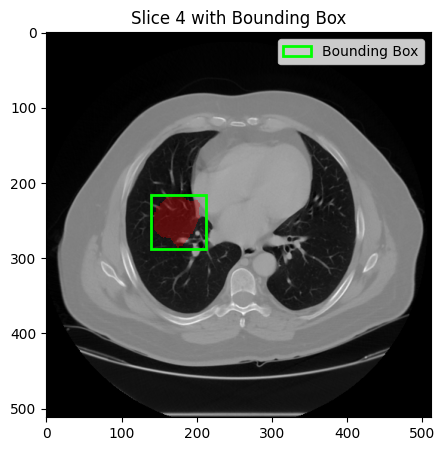

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Metrics BEFORE post-processing:
Dice Coefficient: 0.424
Jaccard Index: 0.269
Voxel Accuracy: 0.988

Metrics AFTER post-processing:
Dice Coefficient: 0.424
Jaccard Index: 0.269
Voxel Accuracy: 0.988

Visualizing results at centroid slice...


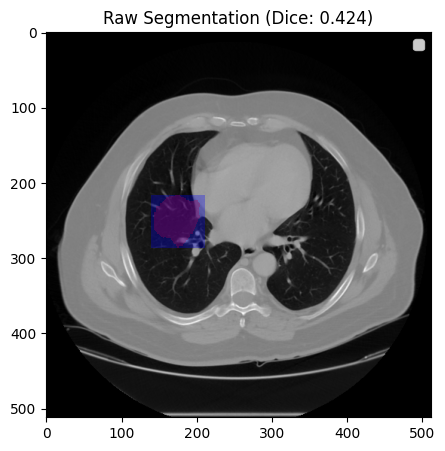

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


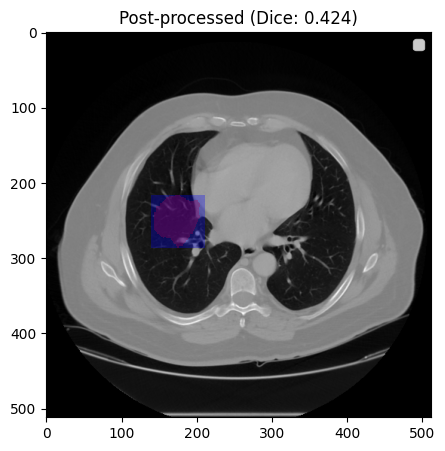

In [253]:
exec()